#Scikit-Learn



*   É considerada como a biblitoca de Python mais utilizada para a implementação de métodos baseados em algoritmos de aprendizagem de máquina (*machine learning*).
* A versão atual é a 0.24.1 (janeiro 2021).
*   URL: http://scikit-learn.org



#Formulação do Problema



*   Problema de classificação **supervisionada** de texto.
*   Hoje iremos investigar o método de aprendizagem de máquina que seja mais apropriado para resolvê-lo.
* Considere um site notícias que publica matérias jornalísticas de vários temas. 
* Economia, saúde e esportes são exemplos de temas. 
* O objetivo é criar um método classificador que receba um texto de entrada e consiga identificar qual é o assunto do texto.
* O classificador assume que cada texto está associado a um tema.
* É um problema de classificação de texto multiclasses.


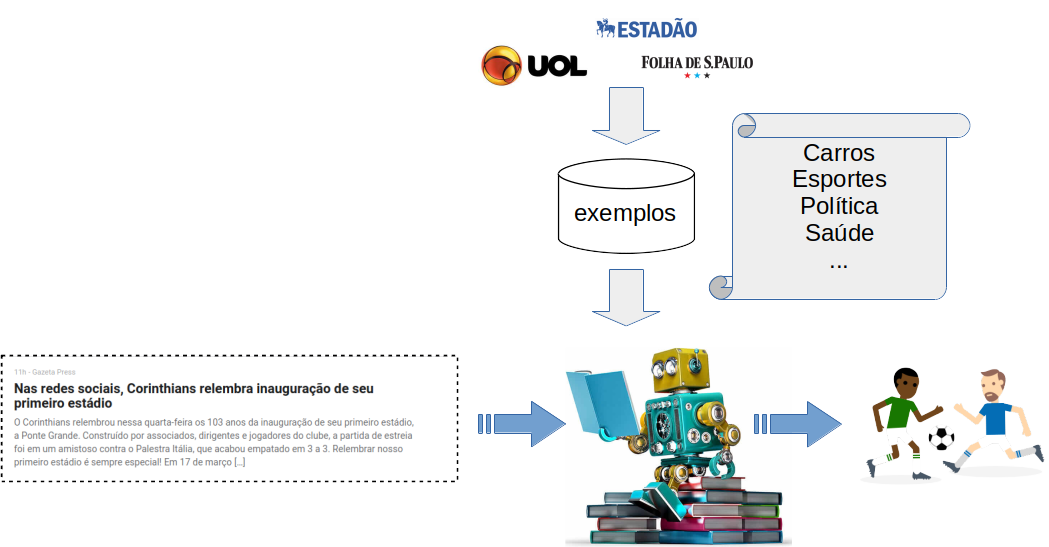

# Exploração dos Dados

### Carregar *dataset*

In [39]:
import pandas as pd

In [40]:
df = pd.read_csv('http://tiagodemelo.info/datasets/dataset-uol.csv')
df.head()

,CATEGORIA,TEXTO
0,coronavirus,"Na manhã de ontem, o chefe do Executivo recebe..."
1,coronavirus,Os parentes acreditaram que os dois pudessem e...
2,politica,28.jan.2020 - Equipe médica embarca rumo a Wuh...
3,esporte,A estratégia serve para o Alviverde melhorar a...
4,coronavirus,31.jan.2020 - Tripulação embarca em voo com má...


In [41]:
df.shape

(518227, 2)

In [42]:
df.CATEGORIA.unique()

array(['coronavirus', 'politica', 'esporte', 'carro', 'educacao',
       'entretenimento', 'economia', 'saude'], dtype=object)

### Verificar dados nulos (NaN)

In [43]:
df.isnull().any()

CATEGORIA    False
TEXTO         True
dtype: bool

In [44]:
df.isnull().sum()

CATEGORIA        0
TEXTO        13451
dtype: int64

In [45]:
index_with_nan = df.index[df.isnull().any(axis=1)]
index_with_nan.shape
df.drop(index_with_nan, 0, inplace=True)

In [46]:
df.shape

(504776, 2)

### Adicionar coluna ao *dataset*

In [47]:
ids_categoria = df['CATEGORIA'].factorize()[0]
df['ID_CATEGORIA'] = ids_categoria

In [48]:
df.head(n=10)

,CATEGORIA,TEXTO,ID_CATEGORIA
0,coronavirus,"Na manhã de ontem, o chefe do Executivo recebe...",0
1,coronavirus,Os parentes acreditaram que os dois pudessem e...,0
2,politica,28.jan.2020 - Equipe médica embarca rumo a Wuh...,1
3,esporte,A estratégia serve para o Alviverde melhorar a...,2
4,coronavirus,31.jan.2020 - Tripulação embarca em voo com má...,0
5,coronavirus,"Especialistas em saúde foram afastados, segund...",0
6,carro,"Por exemplo, prazer ao dirigir é algo que eu l...",3
7,educacao,8) Calcular a área do setor circular com ângul...,4
8,coronavirus,Engano. Se chega ao pico da curva quando + 60%...,0
9,coronavirus,"""É cruel pensar assim, mas se eu tivesse a lei...",0


In [49]:
df.ID_CATEGORIA.unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [50]:
column_values = df[["ID_CATEGORIA", "CATEGORIA"]].values.ravel()
unique_values = pd.unique(column_values)
print(unique_values)

[0 'coronavirus' 1 'politica' 2 'esporte' 3 'carro' 4 'educacao' 5
 'entretenimento' 6 'economia' 7 'saude']


In [51]:
category_id_df = df[['CATEGORIA', 'ID_CATEGORIA']].drop_duplicates().sort_values('ID_CATEGORIA')
id_to_category = dict(category_id_df[['ID_CATEGORIA', 'CATEGORIA']].values)
id_to_category

{0: 'coronavirus',
 1: 'politica',
 2: 'esporte',
 3: 'carro',
 4: 'educacao',
 5: 'entretenimento',
 6: 'economia',
 7: 'saude'}

### Distribuição das notícias entre as categorias

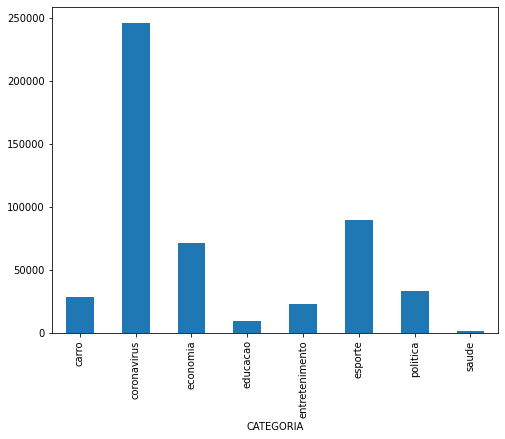

In [52]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

df.groupby('CATEGORIA').TEXTO.count().plot.bar(ylim=0)
plt.show()



*   Um problema recorrente é o **desbalanceamento das classes**.
*   Os algoritmos convencionais tendem a favorecer as classes mais frequentes, ou seja, não consideram as classes menos frequentes.
*  As classes menos frequentes costumam ser tratadas como *outliers*.
* Estratégias de *undersampling* ou *oversampling* são aplicadas para tratar desse problema [[1]](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis).
* Lidar com essas estratégias será discutido posteriormente.




#### Preparar dataset para que todas as categorias tenham a mesma quantidade de publicações

In [53]:
TAMANHO_DATASET = 200 #quantidade de artigos por classe.

In [54]:
categorias = list(set(df['ID_CATEGORIA']))

data = []
for cat in categorias:
  total = TAMANHO_DATASET
  for c,t,i in zip(df['CATEGORIA'], df['TEXTO'], df['ID_CATEGORIA']):
    if total>0 and cat == i:
      total-=1
      data.append([c,t,i])

df = pd.DataFrame(data, columns=['CATEGORIA','TEXTO','ID_CATEGORIA'])

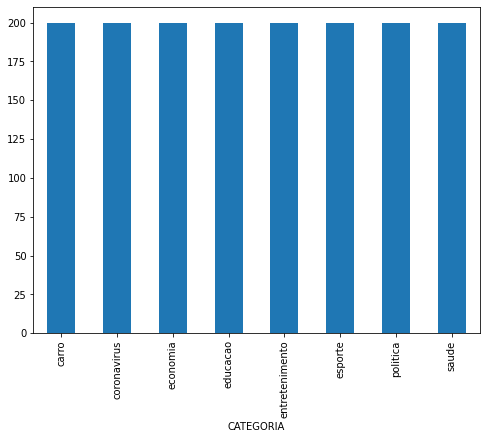

In [55]:
fig = plt.figure(figsize=(8,6))

df.groupby('CATEGORIA').TEXTO.count().plot.bar(ylim=0)
plt.show()

# Representação do Texto



*   Os métodos de aprendizagem de máquina lidam melhor com representações numéricas ao invés de representação textual.
*   Portanto, os textos precisam ser convertidos.
* *Bag of words* é uma forma comum de representar os textos.
* Nós vamos calcular a medida de *Term Frequency* e *Inverse Document Frequency*, abreviada como **TF-IFD**.
* Nós usaremos o `sklearn.feature_extraction.text.TfidfVectorizer` para calcular o `tf-idf`.



Opções (paramêtros) utilizados:

*   `min_df` é o número mínimo de documentos que uma palavra deve estar presente.
* `encoding` é usado para que o classificador consiga lidar com caracteres especiais.
*   `ngram_range` é definida para considerar unigramas e bigramas.
* `stop_words` é definida para reduzir o número de termos indesejáveis.




In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
tfidf = TfidfVectorizer(min_df=5, encoding='latin-1', ngram_range=(1, 2), stop_words=stopwords.words('portuguese'))

features = tfidf.fit_transform(df.TEXTO.values.astype('U')).toarray()
labels = df.ID_CATEGORIA
features.shape

(1600, 1816)

Nós podemos usar o `sklearn.feature_selection.chi2` para achar os termos que estão mais correlacionados com cada categoria.

In [58]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2

for Categoria, category_id in sorted(id_to_category.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Categoria))
  print("  . Unigramas mais correlacionados:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Bigramas mais correlacionados:\n. {}".format('\n. '.join(bigrams[-N:])))

# '0':
  . Unigramas mais correlacionados:
. equipe
. único
  . Bigramas mais correlacionados:
. duas vezes
. entrevista coletiva
# '1':
  . Unigramas mais correlacionados:
. equipe
. único
  . Bigramas mais correlacionados:
. duas vezes
. entrevista coletiva
# '2':
  . Unigramas mais correlacionados:
. equipe
. único
  . Bigramas mais correlacionados:
. duas vezes
. entrevista coletiva
# '3':
  . Unigramas mais correlacionados:
. equipe
. único
  . Bigramas mais correlacionados:
. duas vezes
. entrevista coletiva
# '4':
  . Unigramas mais correlacionados:
. equipe
. único
  . Bigramas mais correlacionados:
. duas vezes
. entrevista coletiva
# '5':
  . Unigramas mais correlacionados:
. equipe
. único
  . Bigramas mais correlacionados:
. duas vezes
. entrevista coletiva
# '6':
  . Unigramas mais correlacionados:
. equipe
. único
  . Bigramas mais correlacionados:
. duas vezes
. entrevista coletiva
# '7':
  . Unigramas mais correlacionados:
. equipe
. único
  . Bigramas mais correlaciona

#Criação de Classificador

Importar bibliotecas:

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

Dividir *dataset* em **treino** e **teste**

In [60]:
X_train, X_test, y_train, y_test = train_test_split(df['TEXTO'], df['CATEGORIA'], test_size=0.2, random_state = 0)

Criar um modelo (Naive Bayes)

In [61]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train.values.astype('U'))
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

Testar o classificador criado:

In [62]:
sentenca = 'O brasileiro gosta de futebol.'
print(clf.predict(count_vect.transform([sentenca])))

['esporte']


#Seleção do Modelo

Nós agora vamos experimentar diferentes modelos de aprendizagem de máquina e avaliar a sua acurácia.

Serão considerados os seguintes modelos:
*   Logistic Regression (LR)
*   Multinomial Naive Bayes (NB)
*   Linear Support Vector Machine (SVM)
*   Random Forest (RF)



Importar bibliotecas:

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

Lista com os modelos:

In [64]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

Uso de validação cruzada com 5 *folds*:

In [65]:
CV = 5

Geração dos modelos:

In [66]:
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

Plotar o gráfico comparativo:

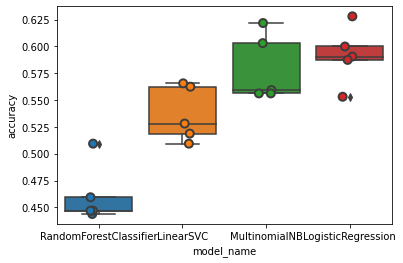

In [67]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

plt.show()

Acurácia média entre os 5 modelos:

In [68]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.536875
LogisticRegression        0.591875
MultinomialNB             0.579375
RandomForestClassifier    0.461250
Name: accuracy, dtype: float64

# Matriz de Confusão

Geração de modelo baseado em SVM:

In [69]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Plotar matriz de confusão para o modelo SVM:

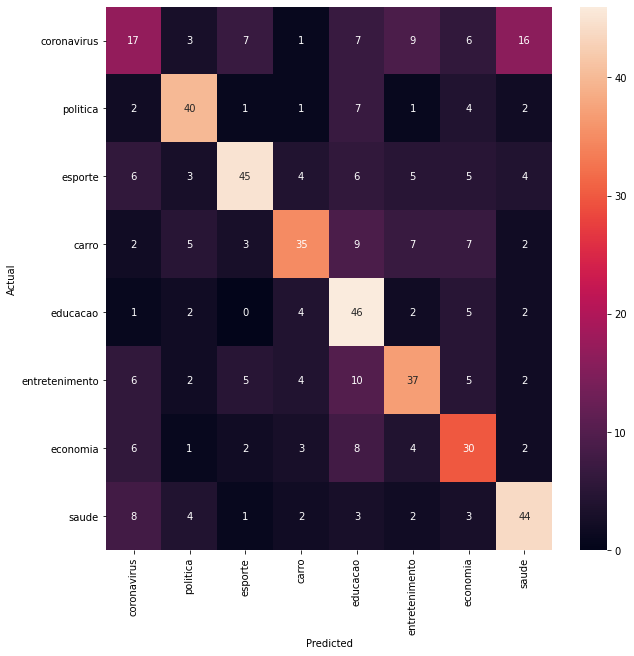

In [70]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.CATEGORIA.values, yticklabels=category_id_df.CATEGORIA.values)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Vamos avaliar os resultados incorretos.

Apresentação de textos classificados incorretamente:

In [71]:
from IPython.display import display

for predicted in category_id_df.ID_CATEGORIA:
  for actual in category_id_df.ID_CATEGORIA:
    if predicted != actual and conf_mat[actual, predicted] >= 5:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['CATEGORIA', 'TEXTO']])
      print('')

'esporte' predicted as 'coronavirus' : 6 examples.


,CATEGORIA,TEXTO
473,esporte,A crônica esportiva contribui. Olha-se menos p...
402,esporte,"A post shared by Yana ""Foxy"" Kunitskaya (@yan..."
583,esporte,"""Risco é nosso. Grande resposta, grande govern..."
489,esporte,"Nesta data FIFA, a França enfrenta a Holanda p..."
443,esporte,"Tempos de João Leite, Guarnelli, Luizinho, Val..."
432,esporte,"Uma das contratações mais midiáticas da época,..."



'entretenimento' predicted as 'coronavirus' : 6 examples.


,CATEGORIA,TEXTO
1005,entretenimento,"""Novos Mutantes"", por fim, havia tido sua estr..."
1194,entretenimento,Paramédicos responderam a um chamado na casa d...
1186,entretenimento,"Pode soar pretensioso, mas os números depõem a..."
1193,entretenimento,"""As pessoas têm a impressão que Brasília não t..."
1054,entretenimento,Imagem: AFP
1038,entretenimento,16.fev.2020 - Ônibus se aproximam do navio de ...



'economia' predicted as 'coronavirus' : 6 examples.


,CATEGORIA,TEXTO
1255,economia,O problema é que pode não ser tão simples assi...
1356,economia,11.mar.2020 - Funcionário de uma estação de ôn...
1228,economia,A ministra destacou ações do governo que serão...
1291,economia,Situações extremas e inusitadas estão se torna...
1357,economia,"Passado um tempo da realização dessa pesquisa,..."
1380,economia,22.jan.2020 - Funcionário de cassino em Macau ...



'saude' predicted as 'coronavirus' : 8 examples.


,CATEGORIA,TEXTO
1531,saude,"""Tivemos que encontrar um nome que não se refe..."
1454,saude,"Dias antes, Teich havia minimizado os recordes..."
1509,saude,"Com isso, o Brasil ultrapassou a China em núme..."
1590,saude,"No estado, o índice de isolamento social na se..."
1520,saude,A Bahia registrou a nona morte decorrente de c...
1412,saude,Representantes de hospitais privados e filantr...
1596,saude,O último plantão dela foi no dia 27 de março. ...
1417,saude,"No Hemolabor, cinco colegas que integravam a e..."



'carro' predicted as 'politica' : 5 examples.


,CATEGORIA,TEXTO
602,carro,"Winterkorn foi acusado por ""fraude"" e ""violaçã..."
646,carro,"Ainda assim, bate aquela vontade de ter todo t..."
726,carro,"Também não recolhem IPVA e, em cidades como Sã..."
751,carro,O projeto terá de passar pela aprovação dos de...
674,carro,A demanda por carros PCD fez o tempo de espera...



'coronavirus' predicted as 'esporte' : 7 examples.


,CATEGORIA,TEXTO
182,coronavirus,"Em mensagem enviada aos pais, a escola america..."
177,coronavirus,Após a Espanha confirmar os primeiros casos de...
192,coronavirus,A Uefa trabalha com datas para retornar o fute...
22,coronavirus,"Com Nelson Teich, Salles e cia, o Sport Club M..."
178,coronavirus,A reportagem apurou que restrições semelhantes...
198,coronavirus,"O técnico do Tottenham, José Mourinho, manifes..."
195,coronavirus,É sempre importante lembrar que o sistema espo...



'entretenimento' predicted as 'esporte' : 5 examples.


,CATEGORIA,TEXTO
1073,entretenimento,A Academia de Artes e Ciências Cinematográfica...
1050,entretenimento,"Ozzy participou da faixa Take What You Want, d..."
1147,entretenimento,O protagonista da história é Miles Morales (vo...
1047,entretenimento,Fui no banheiro voltei tava o Eminem cantando ...
1139,entretenimento,"O outro vencedor do prêmio, ""Les Misérables"", ..."



'coronavirus' predicted as 'educacao' : 7 examples.


,CATEGORIA,TEXTO
80,coronavirus,
191,coronavirus,"O sistema é rápido e eficiente, com bom funcio..."
34,coronavirus,"A perspectiva de contração de 5,3% para o Bras..."
152,coronavirus,"Na entrevista, apesar do momento de incerteza ..."
85,coronavirus,
52,coronavirus,
184,coronavirus,RFI: A França está preparada para enfrentar es...



'politica' predicted as 'educacao' : 7 examples.


,CATEGORIA,TEXTO
315,politica,"Em janeiro de 2015, a dona de casa Rosângela C..."
259,politica,
227,politica,"No Twitter, a hashtag (termos usados para prom..."
360,politica,"Ainda criança, mudou com a família para o cent..."
240,politica,"A articulação, segundo os diálogos, envolveu o..."
204,politica,Não vou dizer que chorei porque estaria mentin...
218,politica,"""Parabéns ao Papa Francisco pelo gesto de comp..."



'esporte' predicted as 'educacao' : 6 examples.


,CATEGORIA,TEXTO
520,esporte,25.jan.2020 - Passageiros usam máscara em vagã...
563,esporte,
554,esporte,Pôsteres de Tóquio-2020 1 / 21 Pôster ofici...
512,esporte,
538,esporte,Fedor Smolov é um jogador inconstante. Ele com...
581,esporte,"Antes chamado de soberano, o Tricolor perdeu f..."



'carro' predicted as 'educacao' : 9 examples.


,CATEGORIA,TEXTO
737,carro,"No caso de Taylor, a fuga acrescenta um novo c..."
654,carro,Ambos incentivos estavam previstos pela Medida...
642,carro,O Blazer e o destino dos trabalhadores sindica...
672,carro,Visual trará formas bem mais arrojadas para co...
703,carro,"Curiosamente, o A 35 não traz a já tradicional..."
757,carro,"""Nosso primeiro passo vai ser uma desmontagem ..."
724,carro,O ideal é alugar o automóvel no aeroporto de P...
748,carro,O novo Golf dever ser apresentado na Europa no...
759,carro,Limusine Graf & Stift



'entretenimento' predicted as 'educacao' : 10 examples.


,CATEGORIA,TEXTO
1100,entretenimento,"Lolla Lounge Pass Geral R$ 3.900 (inteira), R$..."
1018,entretenimento,Babushka Boi não faz parte do último disco de ...
1014,entretenimento,"Dave Grohl canta canta ""Show Me How To Live"""
1108,entretenimento,"Gibbons foi contratado aos 22 anos, em 1915, p..."
1027,entretenimento,"Nas redes sociais, outros sertanejos lamentara..."
1154,entretenimento,"2020, no entanto, seria especial para o Glasto..."
1110,entretenimento,Outra novidade é o lançamento da inédita Depre...
1003,entretenimento,"Bravo, ele perguntava ao leitor: ""Tá olhando o..."
1036,entretenimento,Me desculpe aíMas não compro seu processoDe em...
1101,entretenimento,"Liv Brandão, editora"



'economia' predicted as 'educacao' : 8 examples.


,CATEGORIA,TEXTO
1283,economia,O software de controle de voo é um sistema cha...
1236,economia,Especialistas ouvidos pelo UOL afirmam que os ...
1277,economia,Outra falha bastante comum nas primeiras apres...
1271,economia,"O economista Thiago Xavier, analista da Tendên..."
1217,economia,"Ela destaca que o Artigo 2.º da MP 808 ""discip..."
1323,economia,Os militares consideram fundamental escolher u...
1214,economia,Página faz piada com entrevistas de emprego
1223,economia,



'coronavirus' predicted as 'entretenimento' : 9 examples.


,CATEGORIA,TEXTO
5,coronavirus,"""É cruel pensar assim, mas se eu tivesse a lei..."
14,coronavirus,"Eu tenho dois irmãos, um mais velho e um mais ..."
133,coronavirus,"Nesta quinta (2), a Sony afirmou que The Last ..."
45,coronavirus,"Os pacientes são dois homens, um de 61 anos e ..."
27,coronavirus,"""Houve muita especulação de que Jack Ma estava..."
140,coronavirus,"Assim, vemos alguns dos lugares mais populares..."
29,coronavirus,"Em meio à pandemia do novo coronavírus, o Fest..."
35,coronavirus,O navio Almirante Saboia esteve em Itajaí (SC)...
186,coronavirus,"Na capital Seul, cerca de uma dúzia de fiéis f..."



'esporte' predicted as 'entretenimento' : 5 examples.


,CATEGORIA,TEXTO
458,esporte,"O jogador comprou uma casa em Alphaville, na G..."
530,esporte,"""Esta conta me pertence e esse tal esta utiliz..."
427,esporte,"Cara que transmissão horrível do Premiere, áud..."
438,esporte,Who ended pre-season testing on a high...? It'...
568,esporte,"""[James Dolan, dono dos Knicks] disse para mim..."



'carro' predicted as 'entretenimento' : 7 examples.


,CATEGORIA,TEXTO
620,carro,Salão de Frankfurt: veja as principais novidades
686,carro,Imagem: Divulgação
722,carro,"""Meus pêsames à família, parentes, amigos e me..."
656,carro,Marcas ocidentais e japonesas invadem Salão de...
615,carro,O filme acabou premiado como melhor comercial ...
679,carro,Up Connect era uma série especial e foi in...
775,carro,Quando não está exibindo suas supermáquinas ou...



'coronavirus' predicted as 'economia' : 6 examples.


,CATEGORIA,TEXTO
107,coronavirus,"No entanto, não se trata de uma medida excepci..."
142,coronavirus,"Em 2017, em uma eleição de fachada, Berdimuham..."
108,coronavirus,"""Hoje, iniciam-se atividades produtivas relaci..."
48,coronavirus,A empresa americana Xenex possui o LightStrike...
58,coronavirus,"Em valores monetários, os economistas calculam..."
56,coronavirus,"Tenho amiga que conseguiu antecipar as férias,..."



'esporte' predicted as 'economia' : 5 examples.


,CATEGORIA,TEXTO
526,esporte,1º – Pep Guardiola
436,esporte,"A cada semana, novos episódios serão lançados ..."
494,esporte,Erik (Yokohama Marinos): 15 jogos e 10 gols (d...
564,esporte,"Em 2017, Coaracy foi preso preventivamente pel..."
511,esporte,"Além dele, outros auxiliares e preparadores fí..."



'carro' predicted as 'economia' : 7 examples.


,CATEGORIA,TEXTO
781,carro,"A companhia diz que está ""empenhada em ampliar..."
743,carro,"No último dia 12 de abril, o Ministério da Jus..."
762,carro,"Até agora, a Toyota é a segunda empresa a conf..."
713,carro,Ter um carro roubado ou furtado é o tipo de si...
768,carro,"Além disso, justamente porque precisam cumprir..."
685,carro,Preços com motor 2.0 diesel: R$ 134.990 (Longi...
792,carro,A pesquisa reafirma a conclusão de um estudo f...



'educacao' predicted as 'economia' : 5 examples.


,CATEGORIA,TEXTO
896,educacao,"""Dado que é por demais provável que seja confe..."
987,educacao,a) Qual é a média diária de resíduos produzida...
936,educacao,"Pediatra e consultor da Fundação Abrinq, Yechi..."
959,educacao,Omar foi sucedido por Uthman ibn Affan (644-65...
930,educacao,O grupo é representado por cerca de 10.000 esp...



'entretenimento' predicted as 'economia' : 5 examples.


,CATEGORIA,TEXTO
1122,entretenimento,"O duo Dan + Shay lançou hoje a balada 10,000 H..."
1129,entretenimento,"Em nota, a Disney lamentou a medida, mas garan..."
1188,entretenimento,Programa de competição
1133,entretenimento,Os ingressos para o sábado estão esgotados. Pa...
1086,entretenimento,"Além disso, há a participação especial, sem ca..."



'coronavirus' predicted as 'saude' : 16 examples.


,CATEGORIA,TEXTO
53,coronavirus,"No momento, os casos de covid-19 em São Paulo ..."
76,coronavirus,Nas últimas 24 horas foram mais 67 vítimas do ...
18,coronavirus,"Enquanto as políticas públicas não chegam, ou ..."
19,coronavirus,"""Reforço que, até o momento, continuamos sem t..."
54,coronavirus,"O governador de São Paulo, João Doria (PSDB-SP..."
82,coronavirus,A prefeitura da cidade não divulgou detalhes s...
161,coronavirus,"Para obter a resposta mais rápida, as vacinas ..."
31,coronavirus,"O Ministério da Saúde anunciou hoje, em coleti..."
122,coronavirus,"""Nós temos bons recursos, mas não são infinito..."
4,coronavirus,Engano. Se chega ao pico da curva quando + 60%...


Reportar o resultado do classificador em cada classe:

In [72]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred, target_names=df['CATEGORIA'].unique()))

                precision    recall  f1-score   support

   coronavirus       0.35      0.26      0.30        66
      politica       0.67      0.69      0.68        58
       esporte       0.70      0.58      0.63        78
         carro       0.65      0.50      0.56        70
      educacao       0.48      0.74      0.58        62
entretenimento       0.55      0.52      0.54        71
      economia       0.46      0.54      0.50        56
         saude       0.59      0.66      0.62        67

      accuracy                           0.56       528
     macro avg       0.56      0.56      0.55       528
  weighted avg       0.56      0.56      0.55       528



# Exercícios propostos

*   Nós usamos acurácia como métrica para avaliar os quatro modelos de classificação de texto. Execute novamente o notebook, mas agora usando a métrica F1 e analise os resultados.
*   Pesquise outros modelos de classificação de texto que estão disponíveis no Scikit-Learn e inclua nos experimentos.
*   Execute novamente o notebook, mas agora utilize todo o conjunto de dados (*dataset*). Observe que as classes estarão desbalanceadas. Avalie e compare o resultado com os classificadores treinados em classes balanceadas.
*   Os modelos estão configurados com um conjunto pré-definido de hiperparâmetros. Pesquise e experimente outras possíveis combinações de hiperparâmetros para os modelos e avalie se os resultados irão melhorar. Sugestão: pesquise estratégias como GridSearchCV e RandomizedSearchCV em [LINK](https://scikit-learn.org/stable/modules/grid_search.html#).
*   Pesquise, proponha e experimente outras estratégias para tentar melhorar o resultado alcançado pelos modelos propostos.

